In [1]:
from models.training import GMFTrainer
from models.base_model import GMF
from evaluation.evaluator import Evaluator
from prediction.predict import predict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [2]:
sessions_train_df = pd.read_json('data_files/train_sessions.jsonl', lines=True)
sessions_val_df = pd.read_json('data_files/val_sessions.jsonl', lines=True)
tracks_df = pd.read_json('data_files/tracks.jsonl', lines=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
sigmoid = torch.nn.Sigmoid()
train_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_train_df['user_id'].values),
    torch.LongTensor(sessions_train_df['track_id'].values),
    torch.FloatTensor(sessions_train_df['score'].values)
)

val_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_val_df['user_id'].values),
    torch.LongTensor(sessions_val_df['track_id'].values),
    torch.FloatTensor(sessions_val_df['score'].values)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False
)

unique_users_count = sessions_train_df['user_id'].nunique()
unique_tracks_count = len(tracks_df)

In [4]:
gmf = GMF(unique_users_count + 1, unique_tracks_count + 1, 64, 0.0, True, True, False)

In [5]:
trainer = GMFTrainer(gmf, train_loader, val_loader, device)
train_loss, val_loss = trainer.train_with_weight_decay(
    epochs=3,
    learning_rate=0.001,
    weight_decay=0.01
)

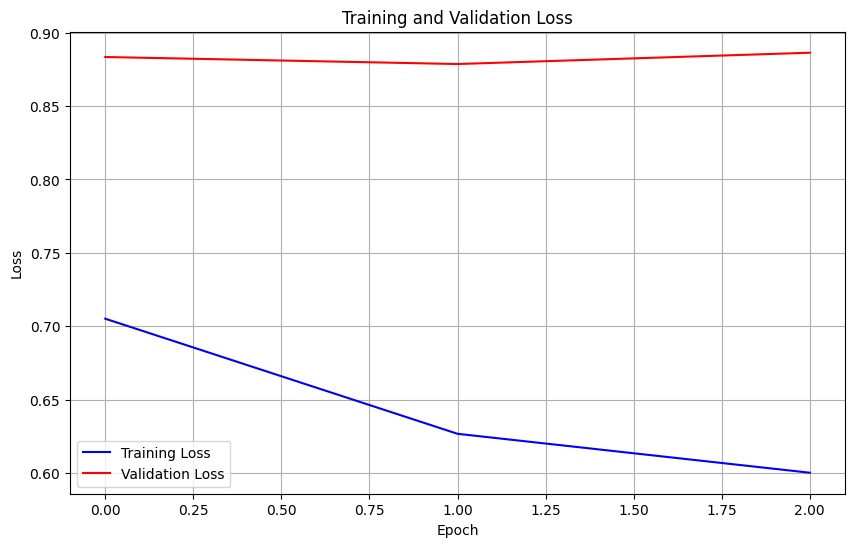

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, 'b-', label='Training Loss')
plt.plot(val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
user_norms = torch.norm(gmf.user_embedding.weight, dim=1)
avg_user_norm = torch.mean(user_norms) 
item_norms = torch.norm(gmf.item_embedding.weight, dim=1)
avg_item_norm = torch.mean(item_norms)

print("Średnia norma user embeddings:", avg_user_norm.item())
print("Średnia norma item embeddings:", avg_item_norm.item())

Średnia norma user embeddings: 0.7595923542976379
Średnia norma item embeddings: 0.5173325538635254


In [8]:
sessions_val_df['score_pred'] = predict(gmf, val_loader, device)
sessions_train_df['score_pred'] = predict(gmf, train_loader, device)

In [9]:
random_ids = np.random.choice(3000, size=1000, replace=False)
selected_train_df = sessions_train_df[sessions_train_df['user_id'].isin(random_ids)]
selected_val_df = sessions_val_df[sessions_val_df['user_id'].isin(random_ids)]

In [17]:
evaluator2 = Evaluator([100, 200, 300, 400, 500], 1.2)

In [18]:
metrics = evaluator2.evaluate(sessions_train_df)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [13]:
for metric, value in metrics.items():
    if metric == ":
        print(f'{metric}: {value * 100}%')

Recall@100: user_id
0        23.411371
1        26.666667
2        12.466125
3       100.000000
4        50.793651
           ...    
2994     87.341772
2995     18.709677
2996    100.000000
2997    100.000000
2998     15.765766
Length: 2999, dtype: float64%
Recall@100_mean: 52.132606968787734%
Recall@100_std: 35.045029529055675%
Precision@100: user_id
0       70.000000
1       44.000000
2       46.000000
3       33.333333
4       64.000000
          ...    
2994    69.000000
2995    58.000000
2996    87.000000
2997    72.000000
2998    35.000000
Length: 2999, dtype: float64%
Precision@100_mean: 58.53395602695189%
Precision@100_std: 15.289363412356947%
Recall@200: user_id
0        42.809365
1        53.333333
2        24.119241
3       100.000000
4       100.000000
           ...    
2994    100.000000
2995     38.709677
2996    100.000000
2997    100.000000
2998     30.630631
Length: 2999, dtype: float64%
Recall@200_mean: 70.42324146476963%
Recall@200_std: 28.848136729209283%
Precisio

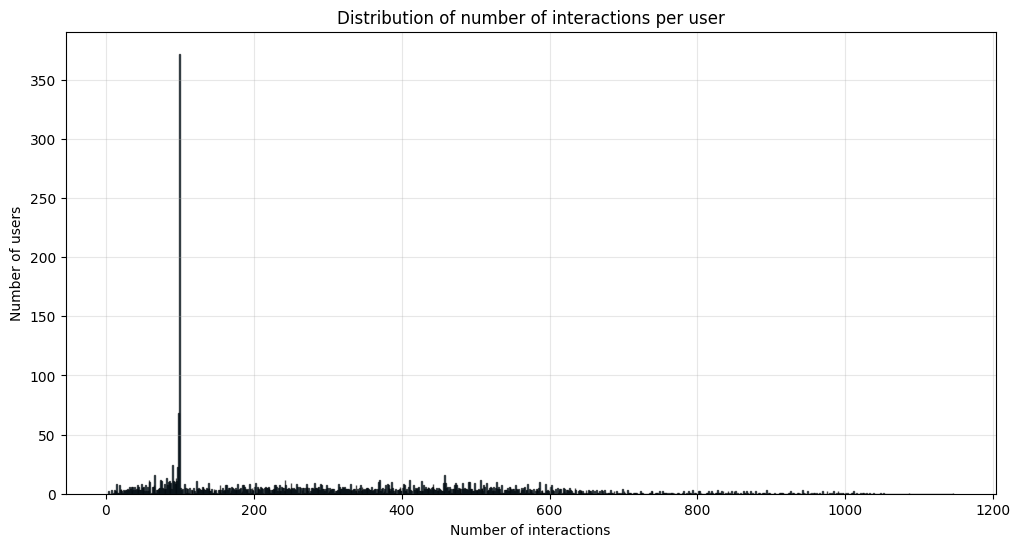

In [19]:
user_interactions = sessions_train_df.groupby('user_id')['track_id'].count()

plt.figure(figsize=(12, 6))
plt.hist(user_interactions, bins=1000, edgecolor='black', alpha=0.7)
plt.title('Distribution of number of interactions per user')
plt.xlabel('Number of interactions')
plt.ylabel('Number of users')
plt.grid(True, alpha=0.3)

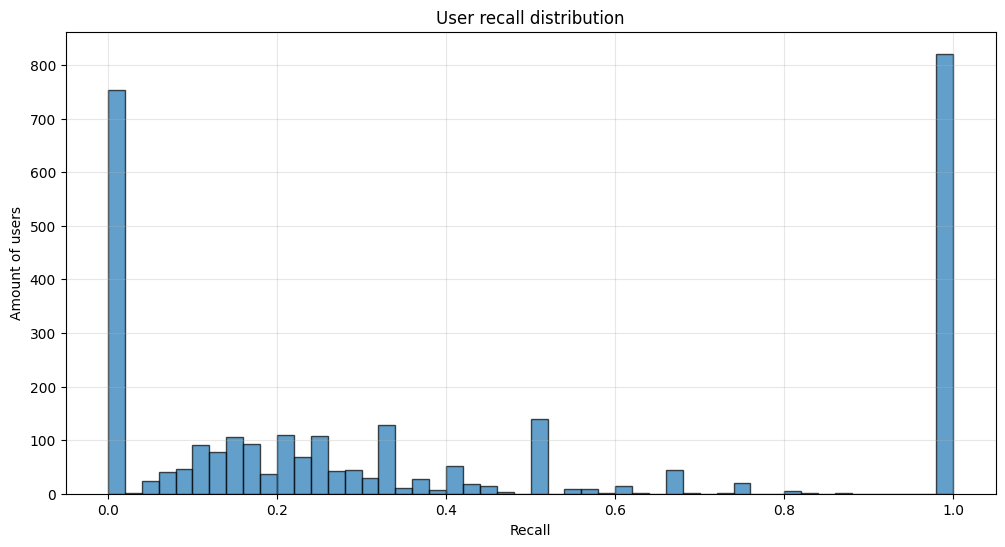

In [22]:
plt.figure(figsize=(12, 6))
plt.hist(metrics['Recall@100'], bins=50, edgecolor='black', alpha=0.7)
plt.title('User recall distribution')
plt.xlabel('Recall')
plt.ylabel('Amount of users')
plt.grid(True, alpha=0.3)

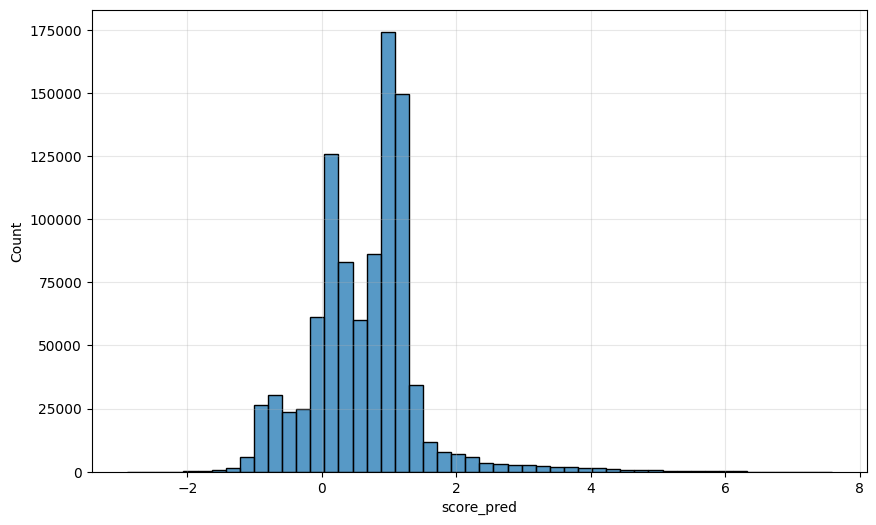

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=sessions_train_df, x='score_pred', bins=50)
plt.grid(True, alpha=0.3)
plt.show()

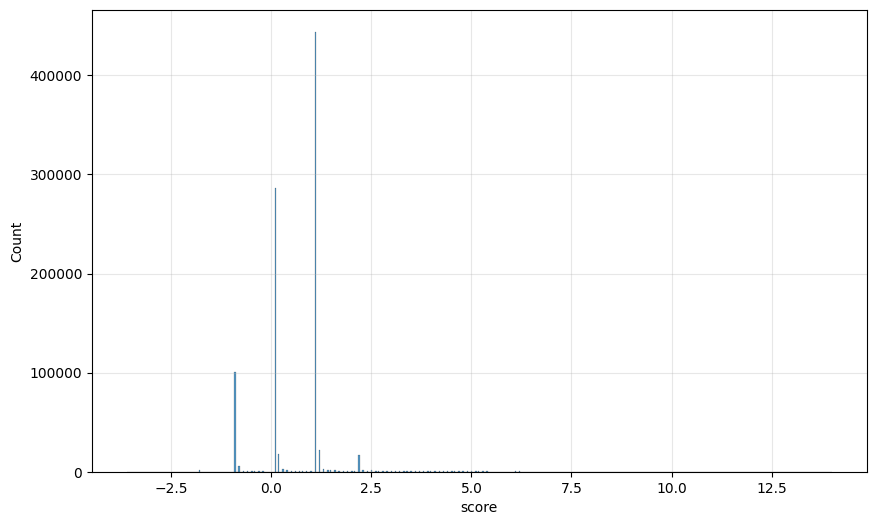

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=sessions_train_df, x='score', bins=500)
plt.grid(True, alpha=0.3)
plt.show()

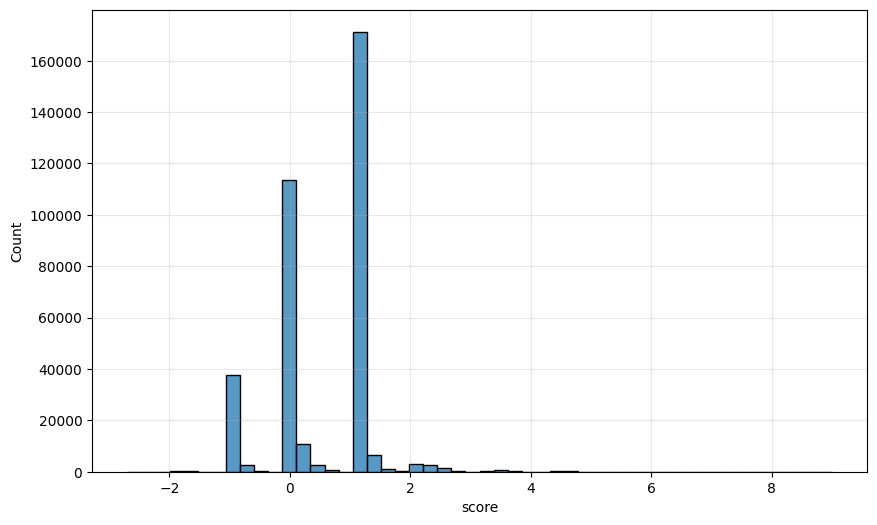

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=sessions_val_df, x='score', bins=50)
plt.grid(True, alpha=0.3)
plt.show()

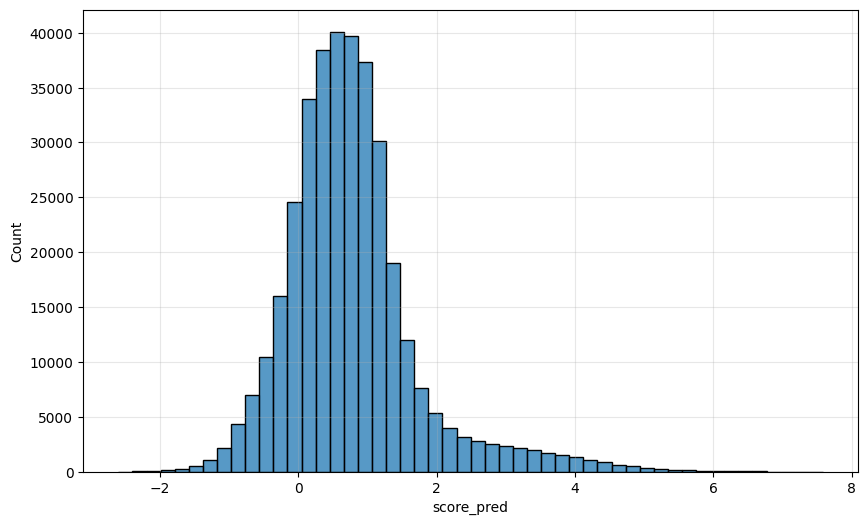

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=sessions_val_df, x='score_pred', bins=50)
plt.grid(True, alpha=0.3)
plt.show()

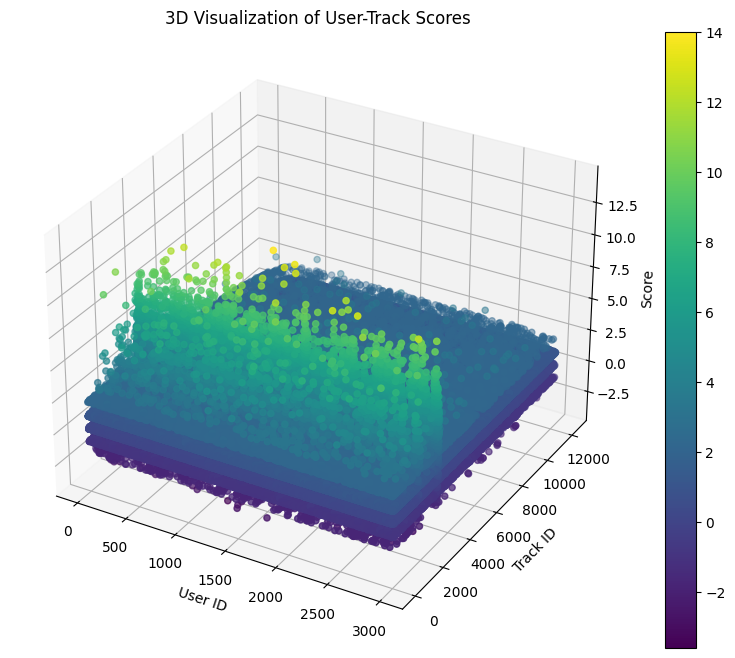

In [25]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
    
scatter = ax.scatter(sessions_train_df['user_id'], 
                    sessions_train_df['track_id'], 
                    sessions_train_df['score'],
                    c=sessions_train_df['score'],
                    cmap='viridis')
    
ax.set_xlabel('User ID')
ax.set_ylabel('Track ID')
ax.set_zlabel('Score')
    
plt.colorbar(scatter)
plt.title('3D Visualization of User-Track Scores')
plt.show()

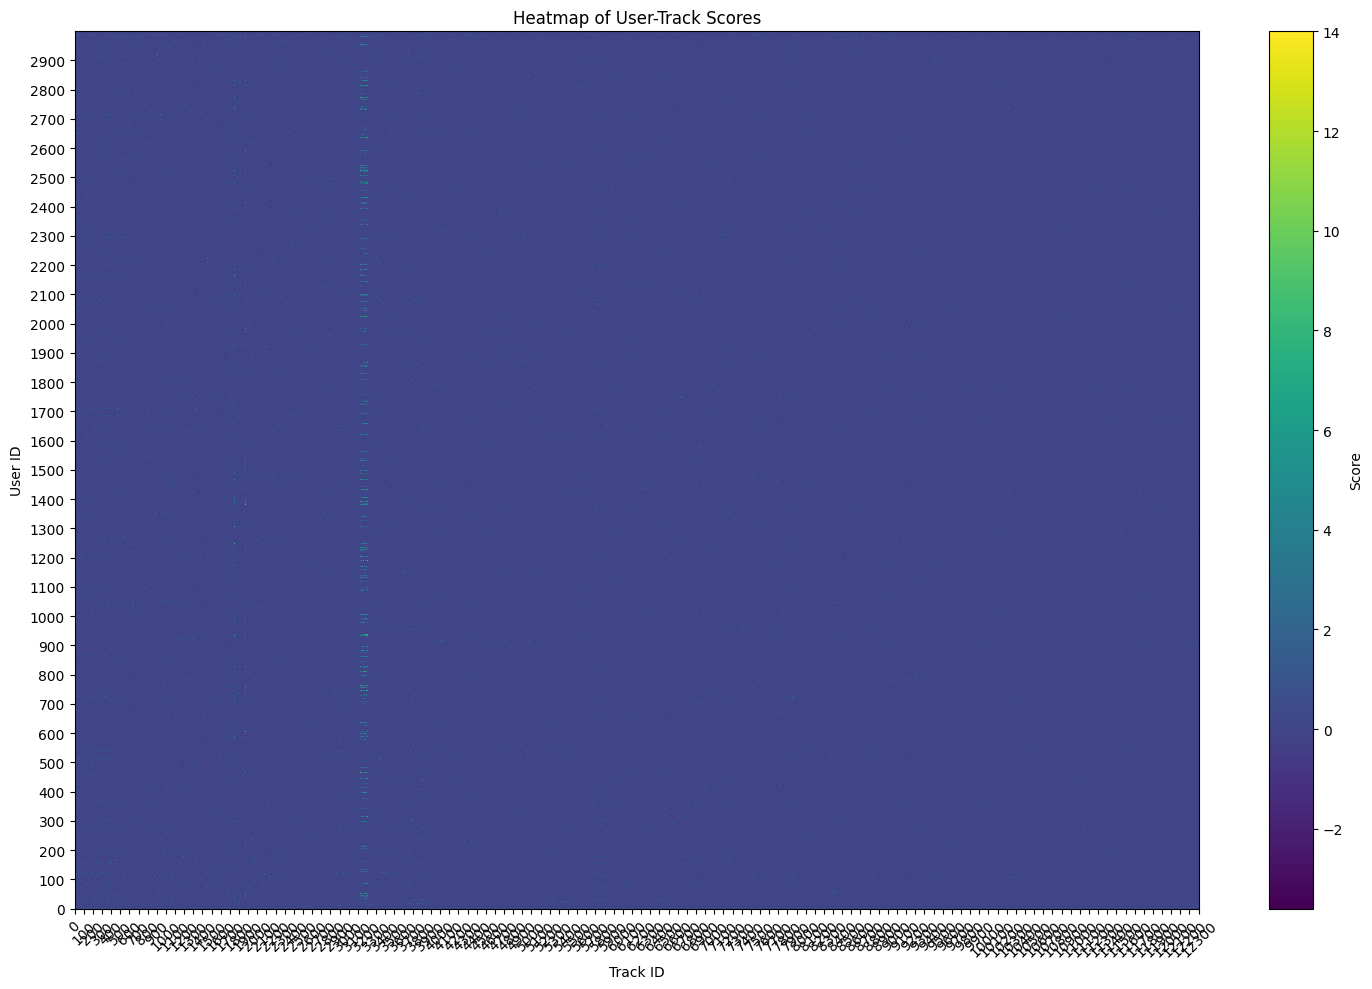

In [3]:
heatmap_data = sessions_train_df.pivot_table(
    values='score',
    index='user_id',
    columns='track_id',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(15, 10))
plt.pcolormesh(heatmap_data, cmap='viridis')
plt.colorbar(label='Score')
plt.title('Heatmap of User-Track Scores')
plt.xlabel('Track ID')
plt.ylabel('User ID')

plt.xticks(np.arange(0, len(heatmap_data.columns), 100), 
          heatmap_data.columns[::100], 
          rotation=45)
plt.yticks(np.arange(0, len(heatmap_data.index), 100), 
          heatmap_data.index[::100])

plt.tight_layout()

plt.show()

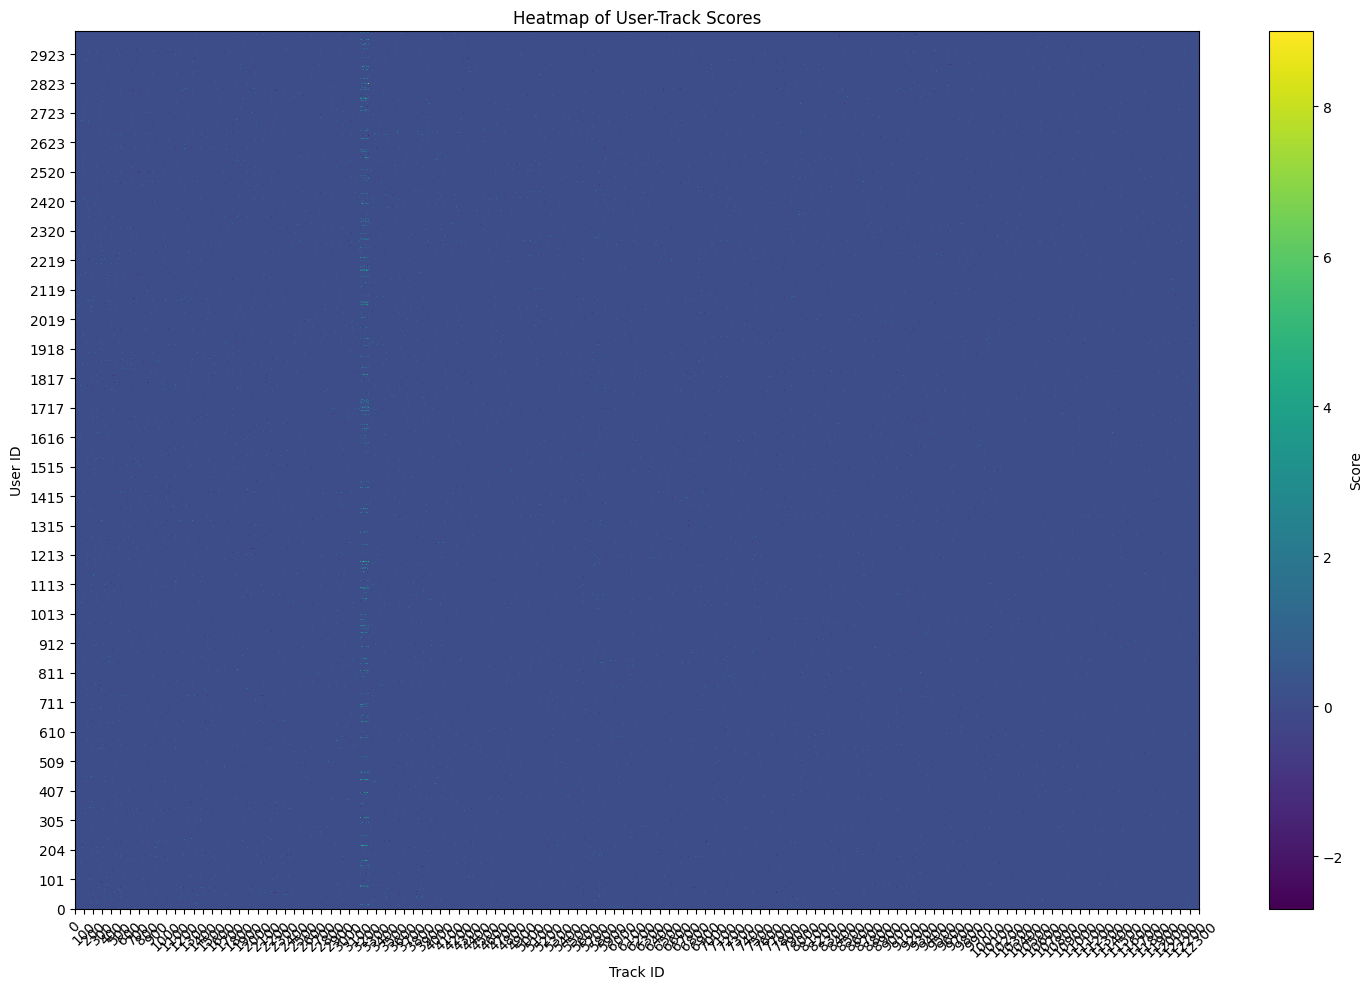

In [3]:
heatmap_data = sessions_val_df.pivot_table(
    values='score',
    index='user_id',
    columns='track_id',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(15, 10))
plt.pcolormesh(heatmap_data, cmap='viridis')
plt.colorbar(label='Score')
plt.title('Heatmap of User-Track Scores')
plt.xlabel('Track ID')
plt.ylabel('User ID')

plt.xticks(np.arange(0, len(heatmap_data.columns), 100), 
          heatmap_data.columns[::100], 
          rotation=45)
plt.yticks(np.arange(0, len(heatmap_data.index), 100), 
          heatmap_data.index[::100])

plt.tight_layout()

plt.show()